In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To do:

try small mu

for loop (convolve one basis at a time)

stop at every location (bandwidths, bubbles, smoothed basis, etc.) check after one iteration if the memory usage increase

In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
# dt = 0.004
# num_steps = 501
dt = 0.002
num_steps = 1001
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([1001, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

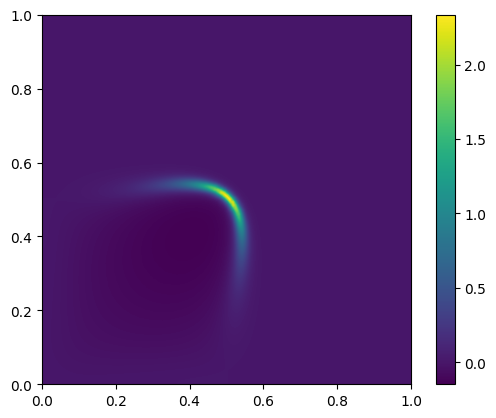

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = torch.hstack((datas[:-1], u_dot))
datas.shape

torch.Size([1000, 29282])

In [8]:
m = 121*121
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

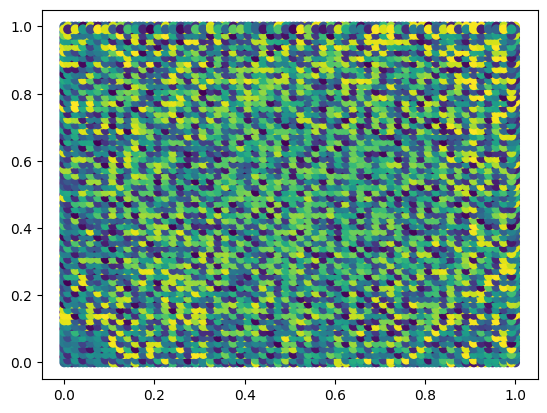

In [9]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

w: n x N

In [10]:
# # distance: N x mu
# # w: n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).expand(n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # n x N x mu
#     return window

In [11]:
# # x: n x N
# # neighbour_id: N x mu
# # w: n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     # n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id] * bubbles, dim=-1)

w: b x n x N

In [12]:
# # distance: N x mu
# # w: b x n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[1]
#     b = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).unsqueeze(0).expand(b, n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # b x n x N x mu
#     return window

In [13]:
# # x(decoder): n x N
# # neighbour_id: N x mu
# # w: b x n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     b = w.shape[0]
#     # b x n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id].unsqueeze(0).expand(b,-1,-1,-1) * bubbles, dim=-1)


In [14]:
N = datas.shape[1] // 2
n = 20
# fixed support (length)
mu = int(np.ceil(N/100))
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [15]:
batch_size = 8
datas = datas.to(device)
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [16]:
ed = lib.nrbs_n_m.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance, clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor), device=device)

In [17]:
ed.nrbs.m

14641

In [18]:
ed.train(train_data_loader=train_data, epochs=100)

100%|██████████| 125/125 [00:17<00:00,  7.12it/s]


Loss = 124.76478063298985


100%|██████████| 125/125 [00:17<00:00,  7.13it/s]


Itr 0, loss = 117.36375796369083


100%|██████████| 125/125 [00:17<00:00,  7.08it/s]


Itr 1, loss = 104.8691275823352


 62%|██████▏   | 77/125 [01:00<00:37,  1.27it/s]

In [ ]:
ed.nrbs = torch.load('models/nrbs_n_m.pth')

In [ ]:
approximates = ed(datas[999:1001, :N].to(device))
approximates.shape

torch.Size([1, 14641])

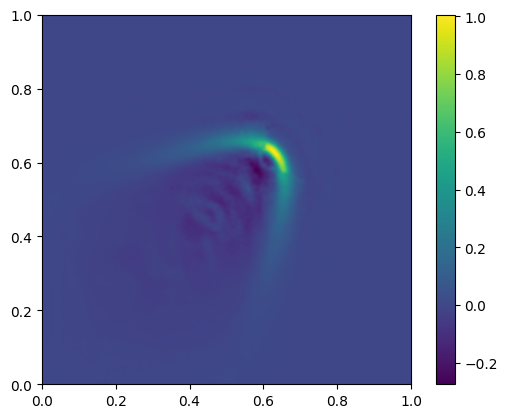

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

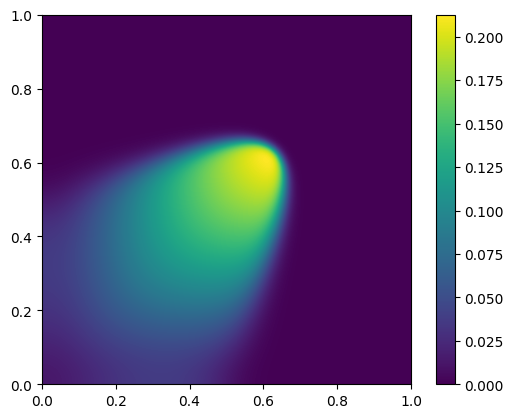

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, :N].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

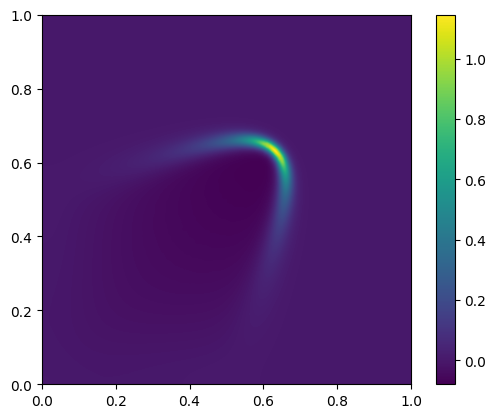

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, N:].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [ ]:
encoded = ed.nrbs.encode(datas[999:1001, :N].to(device))
encoded.shape

torch.Size([1, 20])

In [ ]:
bandwidths = torch.sigmoid(ed.nrbs.bandwidth_layers(encoded[0]))
bandwidths = (1 / 60 - 10 / 60 / ed.nrbs.mu) * bandwidths + 10 / 60 / ed.nrbs.mu
bandwidths = bandwidths.reshape(n, m)
bandwidths = bandwidths[:, ed.nrbs.clustering_labels]

convolved_bases = ed.nrbs.convolve(
                ed.nrbs.decoder.weight,
                ed.nrbs.neighbour_id,
                ed.nrbs.neighbour_distance,
                bandwidths,
                ed.nrbs.mu,
            )

bandwidths = bandwidths.detach().cpu()
convolved_bases = convolved_bases.detach().cpu()

In [ ]:
convolved_bases.shape

torch.Size([20, 14641])

In [ ]:
torch.min(bandwidths)

tensor(0.0023)

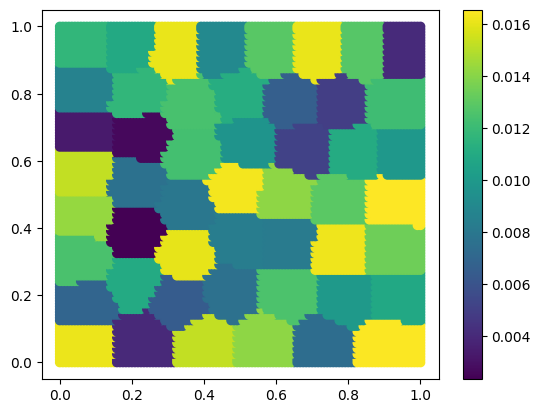

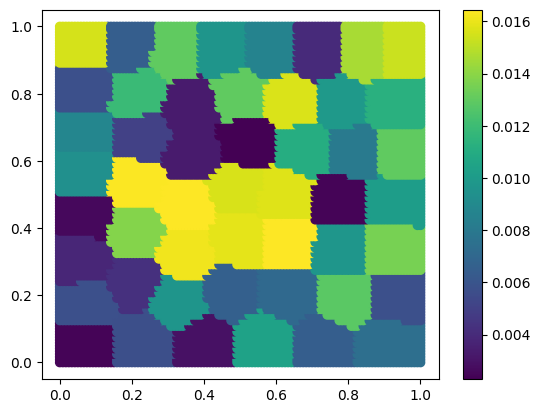

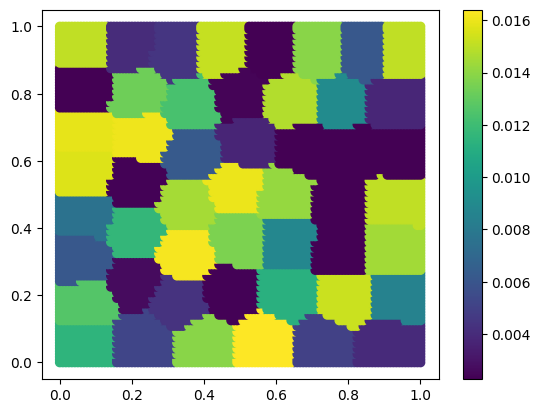

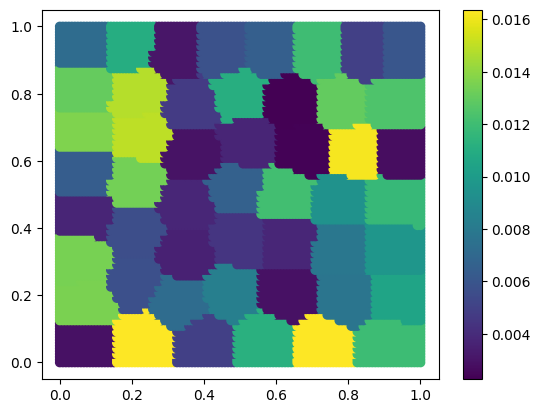

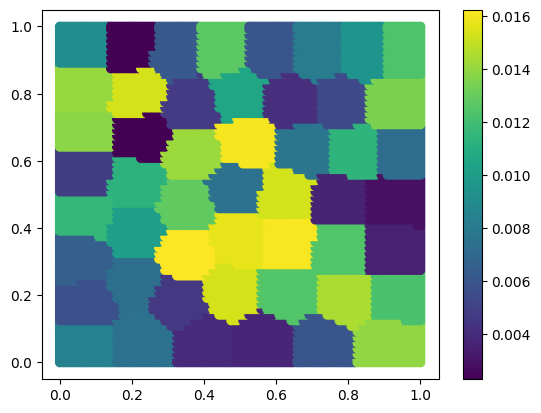

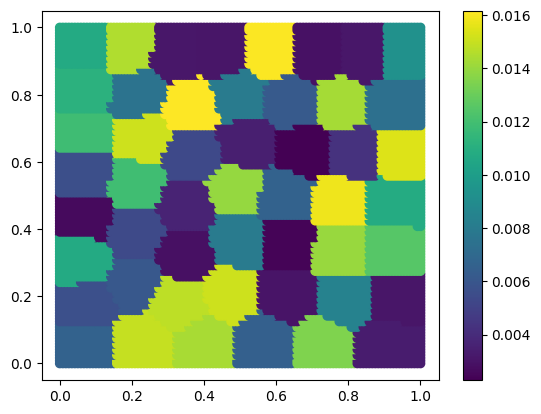

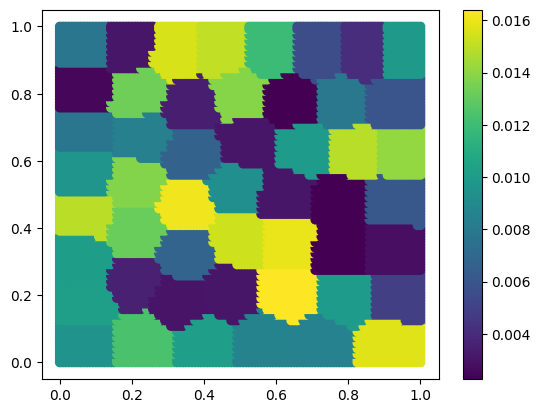

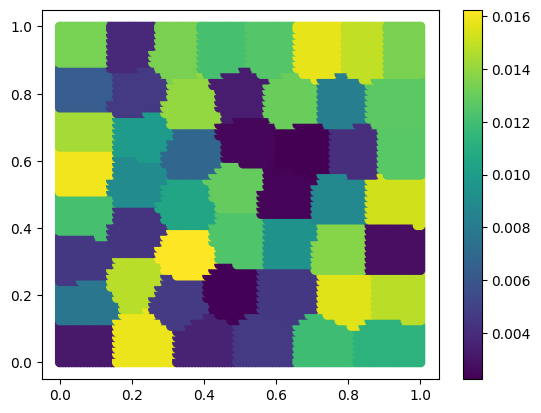

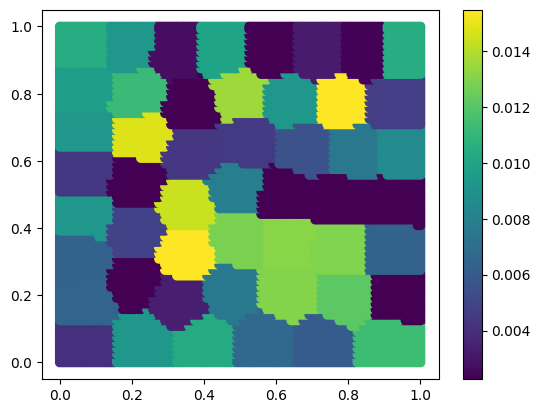

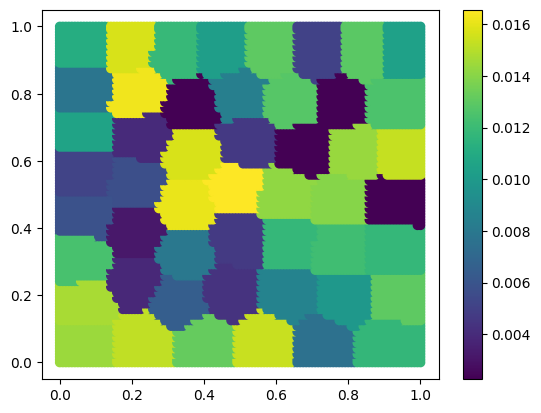

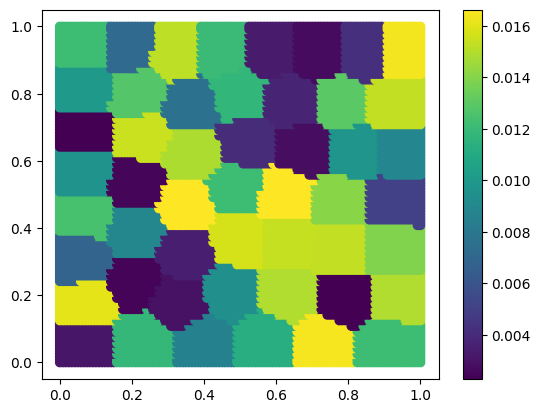

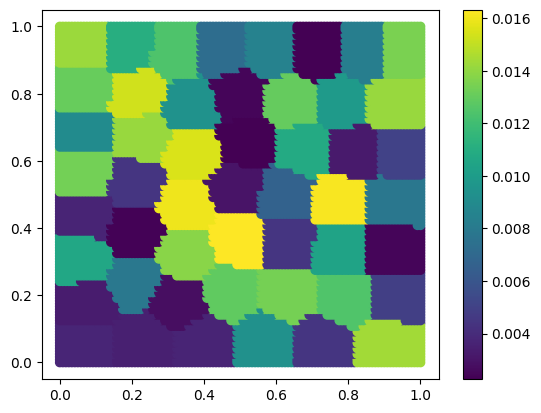

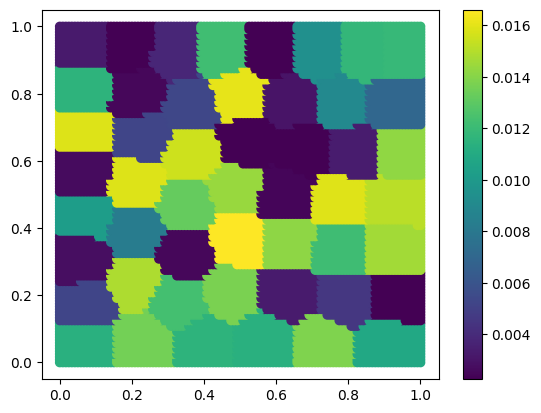

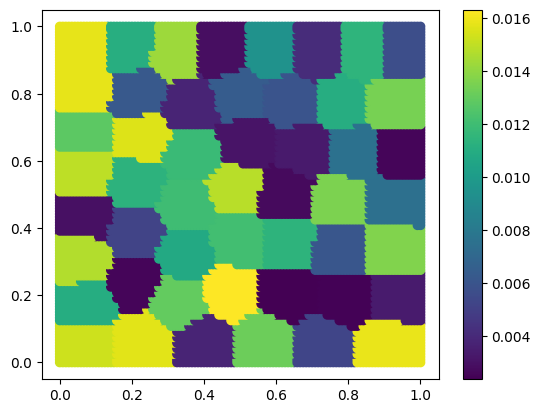

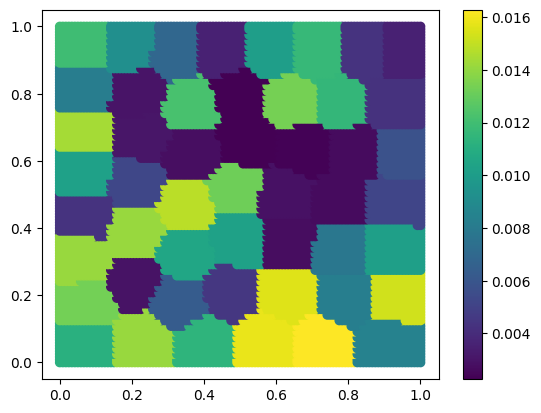

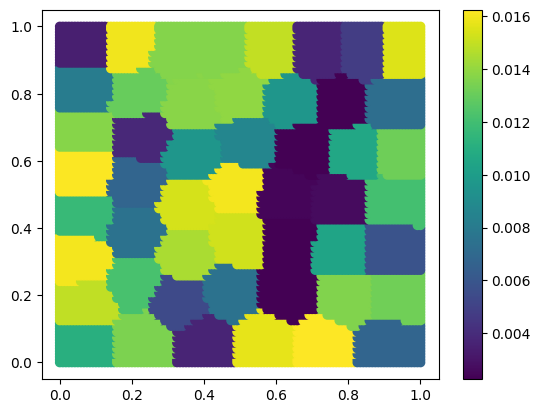

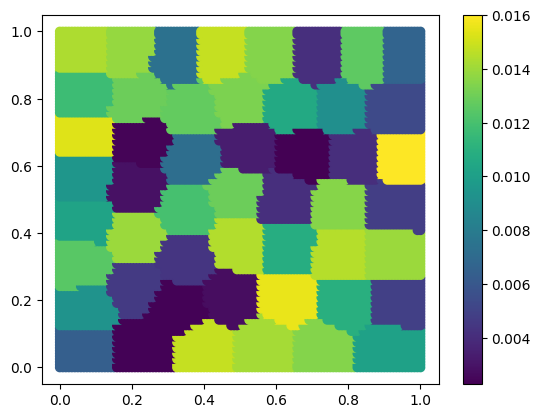

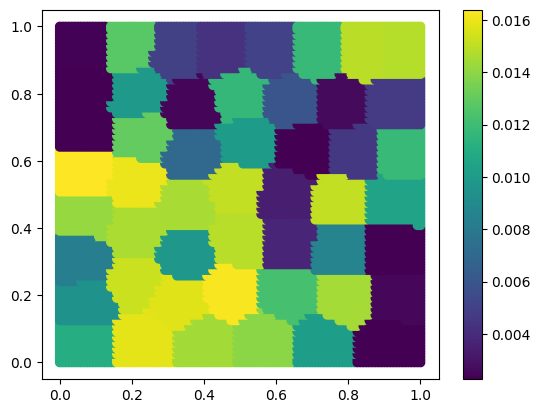

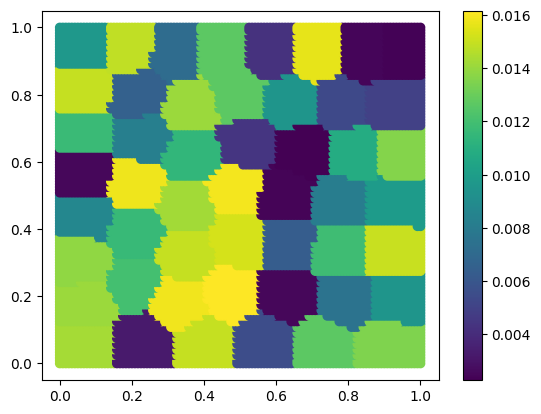

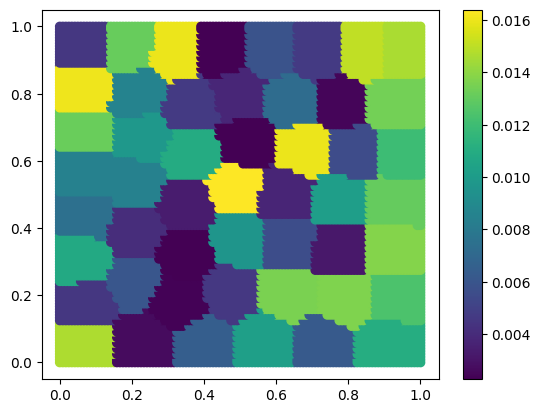

In [ ]:
for basis_id in range(n):
    plt.scatter(coords_x, coords_y,c=bandwidths[basis_id])
    plt.colorbar()
    plt.show()

In [ ]:
bs_n_m = torch.sigmoid(ed.nrbs.bandwidth_layers(encoded[0])) / 60
bs_n_m = bs_n_m.reshape(n, m)
bs_n_m = bs_n_m[:, ed.nrbs.clustering_labels]

In [ ]:
bubbles = ed.nrbs.bubble(neighbour_distance.to(device), bs_n_m, mu)

In [ ]:
bs_n_m

tensor([[0.0160, 0.0160, 0.0160,  ..., 0.0020, 0.0020, 0.0020],
        [0.0002, 0.0002, 0.0002,  ..., 0.0151, 0.0151, 0.0151],
        [0.0107, 0.0107, 0.0107,  ..., 0.0148, 0.0148, 0.0148],
        ...,
        [0.0101, 0.0101, 0.0101,  ..., 0.0145, 0.0145, 0.0145],
        [0.0139, 0.0139, 0.0139,  ..., 0.0001, 0.0001, 0.0001],
        [0.0143, 0.0143, 0.0143,  ..., 0.0143, 0.0143, 0.0143]],
       device='cuda:0', grad_fn=<IndexBackward0>)

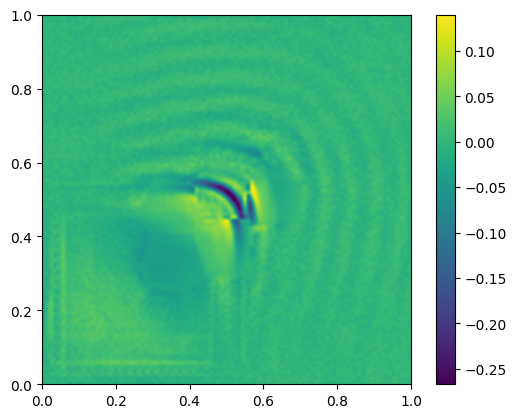

In [ ]:
z = ed.nrbs.decoder.weight[1].tolist()

vmin = min(z)
vmax = max(z)

 # target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1],vmin=vmin,vmax=vmax)
plt.colorbar()
plt.show()


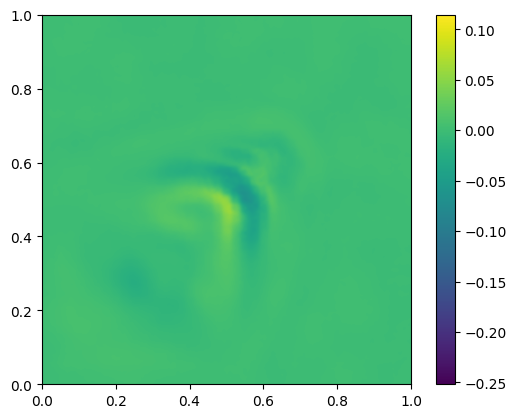

In [ ]:
z = convolved_bases[0].tolist()
# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1],vmin=vmin,vmax=vmax)
plt.colorbar()
plt.show()

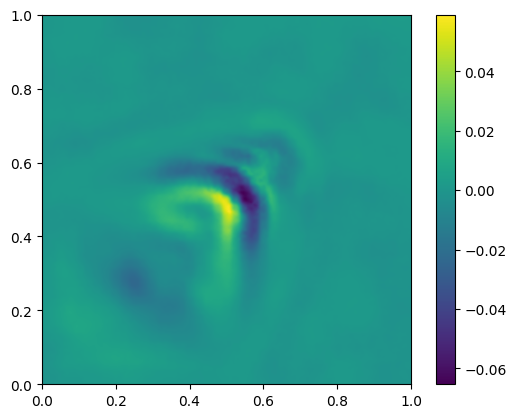

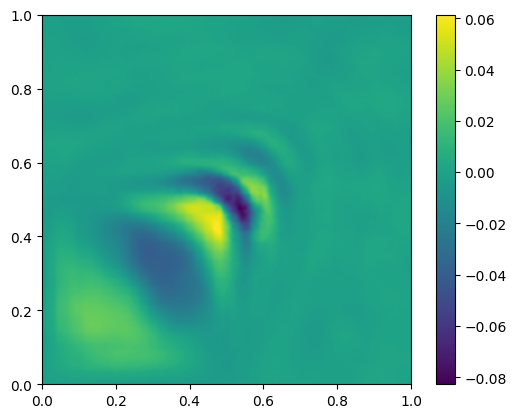

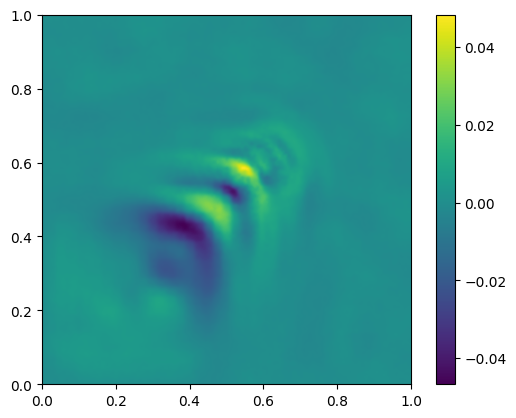

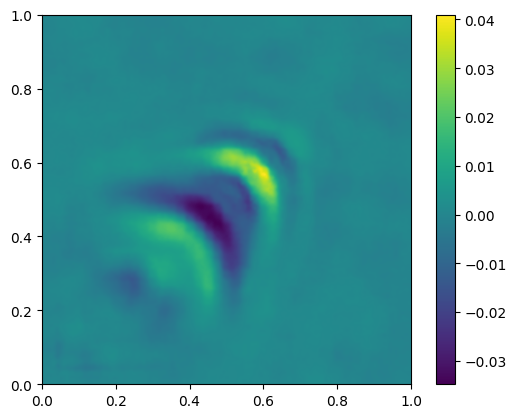

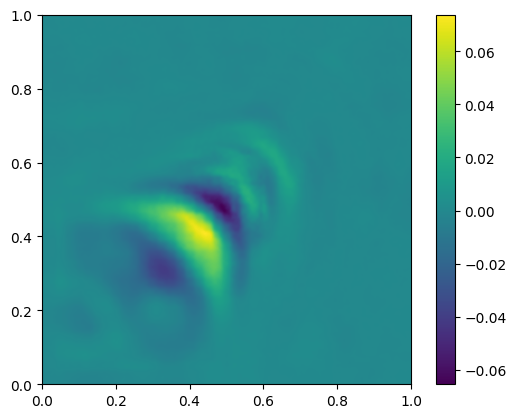

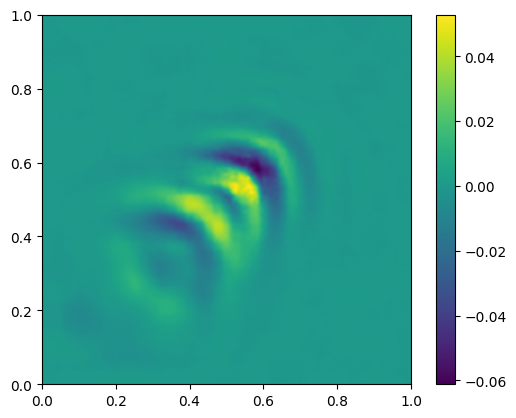

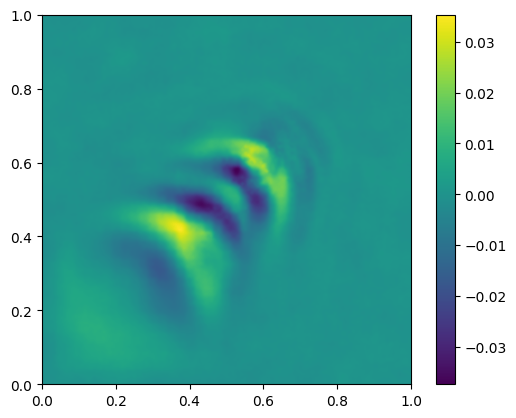

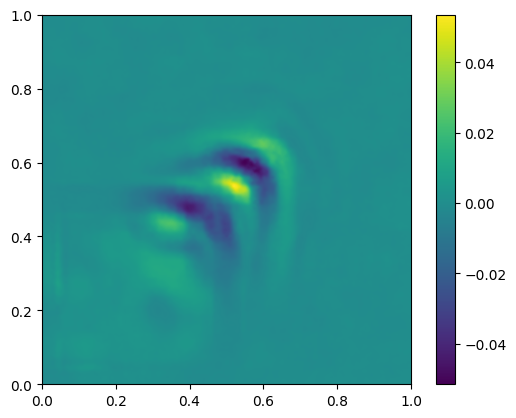

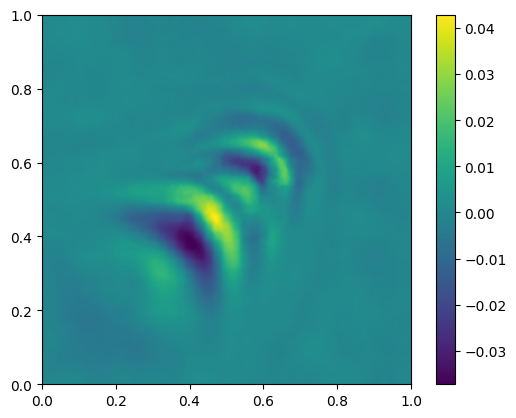

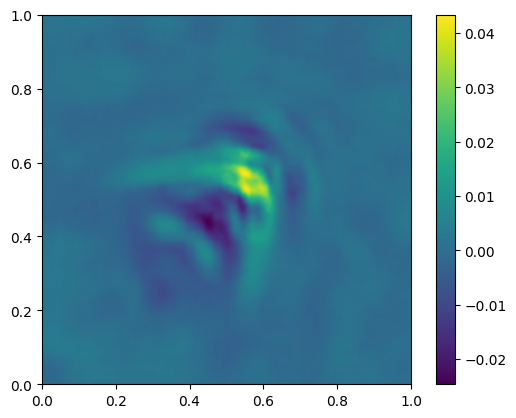

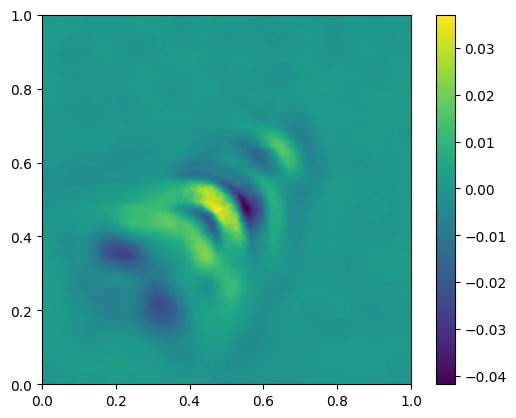

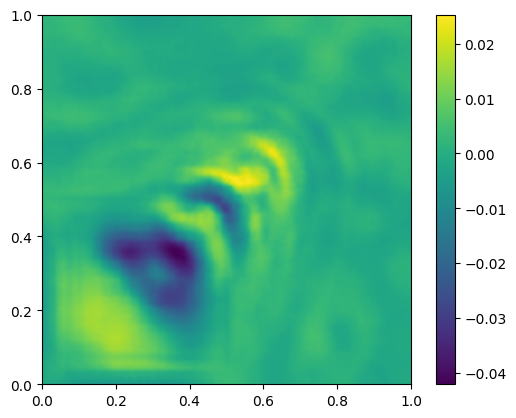

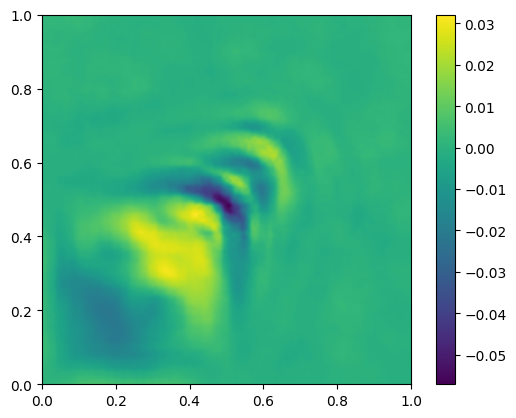

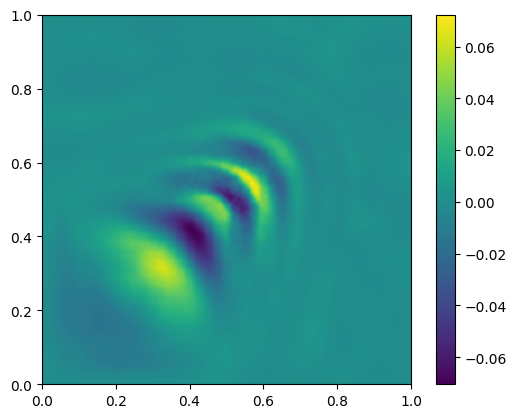

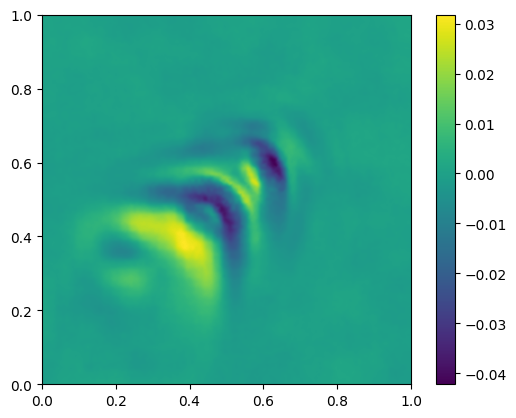

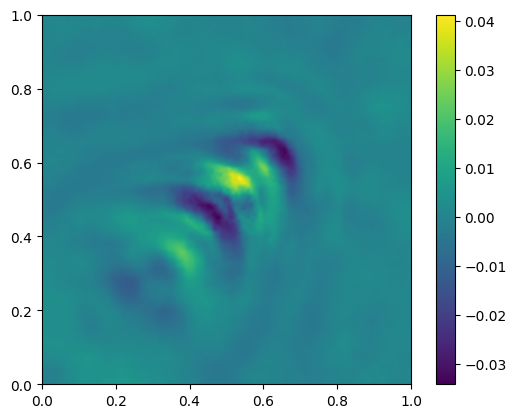

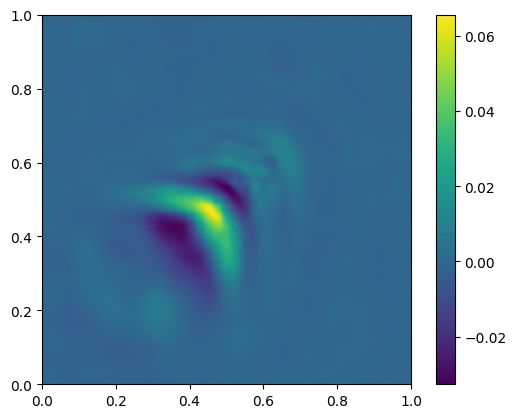

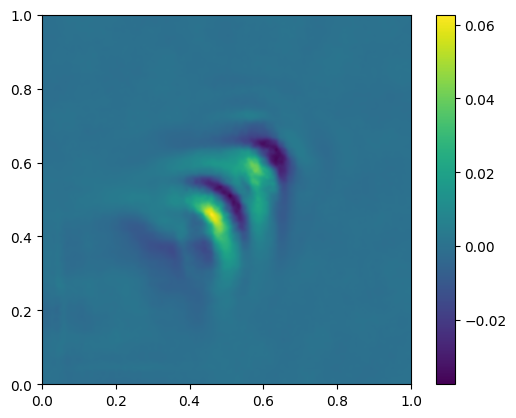

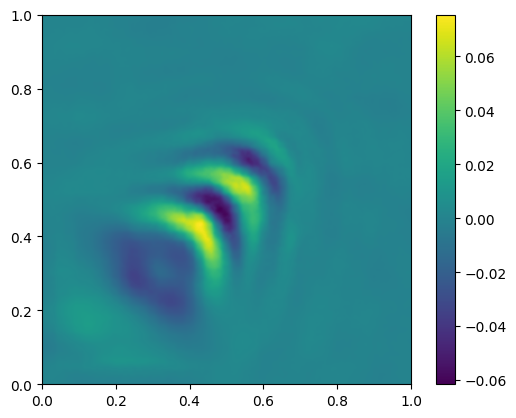

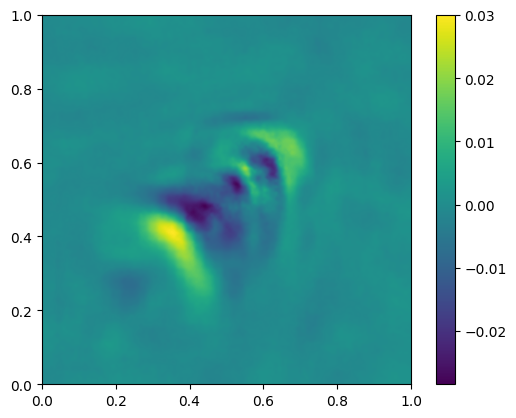

In [ ]:
for basis_id in range(n):
    z = convolved_bases[basis_id].tolist()

    # target grid to interpolate to
    xi = yi = np.linspace(0,1.0,1200)
    xi,yi = np.meshgrid(xi,yi)

    # set mask
    # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='cubic')

    plt.imshow(zi,origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    plt.show()

In [ ]:
# bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
# bws = torch.sigmoid(bws)

In [ ]:
# bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

In [ ]:
# # data coordinates and values
# z = bws[0].detach().cpu().tolist()

# # target grid to interpolate to
# xi = yi = np.linspace(0,1.0,1200)
# xi,yi = np.meshgrid(xi,yi)

# # set mask
# # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# # interpolate
# zi = griddata((x,y),z,(xi,yi),method='cubic')

# plt.imshow(zi,origin='lower', extent=[0,1,0,1])
# plt.colorbar()